# Dive into Witcher 3 sword stats

[Source data](https://thewitcher3.wiki.fextralife.com/Weapons)

Conclusion: It is super easy to guess the damage of a sword given its type and level:
- each level adds 8.4 damage
- being silver adds 110 damage, suggesting monsters have lots more HP than humans
- the first steel sword starts around 13 damage


In [1]:
import bs4 as bs
import pandas as pd
from itertools import zip_longest as zzip
import matplotlib.pyplot as plt 
import statsmodels.api as sm


##########################################
# scrape and build data
# scraped from https://thewitcher3.wiki.fextralife.com/Weapons
##########################################


def get_innerhtml(tag):
    # return a beautifulsoup tag's inner html as asci text
    return tag.encode_contents(None).decode('ascii')

def atoi(s, missing_value=None):
    # str to int, ignoring commas. Return None if error
    try:
        return int(s.replace(',','').replace(' ',''))
    except ValueError:
        return missing_value

def parse_table_soup(soup):
    # return a list of weapons, where each weapon is a dict
    weapons = []
    
    for tr in soup.find_all('tr'):
        cells = tr.find_all('td')
        if len(cells) == 0: # skip header row
            continue
            
        weapon = {}
        # name
        weapon['name'] = cells[0].find('h4').text.strip(' ')
        # blacksmith, level, item
        for i,e in enumerate(cells[0].find('h4').next_siblings):
            # NavigableString is raw text - https://stackoverflow.com/a/5275918
            s = e if isinstance(e, bs.NavigableString) else e.text
            s = s.strip(' ').lower()
            if 'blacksmith' in s: # 'amateur blacksmith required'
                weapon['blacksmith'] = s.split(' ')[0]
            elif 'level' in s: # 'required level 1'
                weapon['level'] = atoi(s.split(' ')[2])
            elif 'item' in s or 'gear' in s: # 'magic item' or 'witcher gear'
                weapon['rarity'] = s.split(' ')[0]
        # dmg
        weapon['dmg'] = atoi(cells[1].text)
        # bonus 1 to 5
        bonuses = get_innerhtml(cells[3]).split('<br/>')
        for i, b in zzip(range(1,6), bonuses): # like enumerate, but None if token missing
            weapon['bonus'+str(i)] = b.strip(' ').lower() if b else ''
        # location
        weapon['location'] = cells[5].text
        # add to list
        weapons.append(weapon)
        
    return weapons


def build_df(filename):
    """ return a dataframe where each row is a sword """
    with open(filename, 'r') as f:
        d = parse_table_soup(bs.BeautifulSoup(f.read(), 'lxml'))
        return pd.DataFrame(d)
    
def build_dataset():
    """ build dataset from the silver and steel tables """
    f1 = 'witcher_data/steel.html'
    f2 = 'witcher_data/silver.html'
    df1 = build_df(f1)
    df1['stype'] = 'steel'
    df2 = build_df(f2)
    df2['stype'] = 'silver'
    return pd.merge(df1,df2,how='outer')
    

df = build_dataset()
df.head()

,name,blacksmith,rarity,level,dmg,bonus1,bonus2,bonus3,bonus4,bonus5,location,stype
0,Koviri Cutlass,amateur,master,1.0,30,none,,,,,Random Loot,steel
1,Temerian Poniard,amateur,master,1.0,35,none,,,,,Random Loot,steel
2,Velen Longsword,amateur,magic,1.0,38,none,,,,,Random Loot,steel
3,Dorian Sword,amateur,magic,2.0,45,none,,,,,Random Loot,steel
4,Serpentine Steel Sword,amateur,witcher,2.0,55,chance to poison: +15%,bonuses experience from humans and nonhumans: +5%,,,,Bandit Camp southwest of Ransacked Village (Wh...,steel


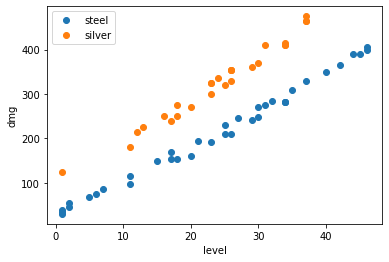

In [2]:
##########################################
# plot
##########################################
def scatter_plot(df,x,y,groupby=None,legend='upper right'):
    """ Draw a scatter plot.
    ::df must be a panda. 
    ::x, ::y, and ::groupby are column names.
    ::legend can be None or '' to not draw it. 
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.xlabel(x)
    plt.ylabel(y)
    if groupby:
        for grp in df[groupby].unique():
            ax.plot(df[df[groupby]==grp][x], df[df[groupby]==grp][y], marker='o', linestyle='', label=grp)
    else:
        ax.plot(df[x],df[y],marker='o',linestyle='')
    if legend:
        ax.legend(loc=legend) # https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend
    plt.show()

scatter_plot(df,'level','dmg',groupby='stype',legend='upper left')

In [3]:
def pretty_print_ols_summary(fit):
    """ concise alternative to sm.OLS().fit().summary() """
    # use dir(fit) to list properties
    formula = fit.model.endog_names+ ' ~ '+ ' + '.join(fit.model.exog_names)
    print(formula, f'---- adj r2={fit.rsquared_adj:.2f}')
    for param, beta in fit.params.items():
        print(f'-- {param}: beta={beta:.2f}, p={fit.pvalues.get(param):.2f}')


def ols_fit(df, outcome_colname, predictor_colnames, add_intercept=True):
    """ ordinary least square fit on dataframe """
    data = df[predictor_colnames].copy() # avoid warning of setting on copy
    data['intercept'] = 1
    linreg = sm.OLS(df[outcome_colname], data)
    return linreg.fit()


df['is_silver'] = (df['stype'] == 'silver').astype(int)
ddf = df[['is_silver','dmg','level']].dropna()
fit = ols_fit(ddf, 'dmg', ['level','is_silver'])
pretty_print_ols_summary(fit)

dmg ~ level + is_silver + intercept ---- adj r2=0.98
-- level: beta=8.41, p=0.00
-- is_silver: beta=110.03, p=0.00
-- intercept: beta=13.42, p=0.00
